Created by [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />
**For questions/comments/improvements, email nathan.kelber@ithaka.org.**<br />
![CC BY License Logo](https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png)
____
# Exploring Word Frequencies

**Description of methods in this notebook:**
This [notebook](https://docs.tdm-pilot.org/key-terms/#jupyter-notebook) shows how to explore the [word frequencies](https://docs.tdm-pilot.org/key-terms/#word-frequency) of your [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor) and/or [Portico](https://docs.tdm-pilot.org/key-terms/#portico) [dataset](https://docs.tdm-pilot.org/key-terms/#dataset) using [Python](https://docs.tdm-pilot.org/key-terms/#python). The following processes are described:

* Converting your [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor) and/or [Portico](https://docs.tdm-pilot.org/key-terms/#portico)[dataset](https://docs.tdm-pilot.org/key-terms/#dataset) into a Python list
* Creating a raw word frequency count
* Creating and modifying a [stop words list](https://docs.tdm-pilot.org/key-terms/#stop-words)
* Cleaning up the [corpus](https://docs.tdm-pilot.org/key-terms/#corpus)
* Create a new word frequency list focused on [content words](https://docs.tdm-pilot.org/key-terms/#content-words)

**Difficulty:** Intermediate

**Knowledge Required:** 
* [Python Basics I](./0-python-basics-1.ipynb)
* [Python Basics II](./0-python-basics-2.ipynb)
* [Python Basics III](./0-python-basics-3.ipynb)

**Knowledge Recommended:**
* [Exploring Metadata](https://docs.tdm-pilot.org/exploring-metadata/)
* A familiarity with [The Natural Language Toolkit](https://docs.tdm-pilot.org/key-terms/#nltk) and [Counter objects](https://docs.tdm-pilot.org/key-terms/#python-counter) is helpful

**Completion time:** 60 minutes

**Data Format:** [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor)/[Portico](https://docs.tdm-pilot.org/key-terms/#portico) [JSON Lines (.jsonl)](https://docs.tdm-pilot.org/key-terms/#jsonl)

**Libraries Used:**
* **[json](https://docs.tdm-pilot.org/key-terms/#json-python-library)** to convert our dataset from json lines format to a Python list
* **[NLTK](https://docs.tdm-pilot.org/key-terms/#nltk)** to help [clean](https://docs.tdm-pilot.org/key-terms/#clean-data) up our dataset
* **Counter** from the **Collections** module to help sum up our word frequencies
___

## Import your dataset

We'll use the tdm_client library to automatically retrieve the dataset in the JSON file format. 

Enter a [dataset ID](https://docs.tdm-pilot.org/key-terms/#dataset-ID) in the next code cell. 

If you don't have a dataset ID, you can:
* Use the sample dataset ID already in the code cell
* [Create a new dataset](https://tdm-pilot.org/builder)
* [Use a dataset ID from other pre-built sample datasets](https://tdm-pilot.org/dataset/dashboard)

In [1]:
# Creating a variable `dataset_id` to hold our dataset ID
# The default dataset is Shakespeare Quarterly, 1950-present
dataset_id = "7e41317e-740f-e86a-4729-20dab492e925"

In [12]:
# Importing your dataset with a dataset ID
from tdm_package import tdm_client
# Load the sample dataset, the full run of Shakespeare Quarterly from 1950-2013.
dataset_json_file = tdm_client.get_dataset(dataset_id)

INFO:root:Downloading 7e41317e-740f-e86a-4729-20dab492e925 to 7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz


100% |########################################################################|


If you completed pre-processing with the "Exploring Metadata and Pre-processing" notebook, you can use your CSV file of dataset IDs to automatically filter the dataset. Your pre-processed CSV file  must be in the root folder.

In [23]:
# Import a pre-processed CSV file of filtered dataset IDs.
# If you do not have a pre-processed CSV file, the analysis
# will run on the full dataset and may take longer to complete.
import pandas as pd
try: 
    df = pd.read_csv('pre-processed_' + dataset_id + '.csv')
    print('Pre-Processed CSV Read Successfully')
except: print('No pre-processed CSV file found')

Pre-Processed CSV Read Successfully


In [24]:
# Create a Python list called `filtered_id_list` from the IDs
# in the CSV file
try: filtered_id_list = df["id"].tolist()
except: filtered_id_list = None

In [25]:
import json
import gzip
from collections import Counter

# Create a Counter container called `word_frequency` to hold
# the word counts for every word in the corpus
word_frequency = Counter()

In [26]:
with gzip.open(dataset_json_file, "rb") as input_file:
    for row in input_file:
        document = json.loads(row)
        if filtered_id_list != None:
            _id = document["id"]
            if _id in filtered_id_list:
                unigrams = document.get("unigramCount", [])
                for gram, count in unigrams.items():
                    word_frequency[gram] += count     
        else: 
            unigrams = document.get("unigramCount", [])
            for gram, count in unigrams.items():
                word_frequency[gram] += count

In [27]:
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

the                  793511
of                   605706
and                  458592
in                   315479
to                   288062
a                    226041
is                   143979
that                 139906
by                   126013
as                   120659
for                  110686
The                  100063
his                  95397
with                 85711
on                   73323
at                   59554
he                   55689
not                  54923
from                 54682
was                  54295
it                   53575
Shakespeare          50055
be                   49095
pp.                  48731
an                   47311


In [28]:
# Load the nltk corpus stopwords in English
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [43]:
transformed_word_frequency = Counter()

In [44]:
for document in tdm_client.dataset_reader(dataset_json_file):
    _id = document["id"]
    if _id in filtered_id_list:
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = gram.lower()
            if clean_gram in stop_words:
                continue
            if not clean_gram.isalpha():
                continue
            transformed_word_frequency[clean_gram] += count
        

In [ ]:
# A series of tests to see whether a token should be added to our final word count.
# In order for a token to be added, it must pass all these tests.

cleaned_word_counts = Counter() # define a new variable `cleaned_word_counts` that is an empty counter type. We will store our cleaned data in it.

for token, count in counter_word_counts.items(): # For each key (`token`), value (`count`) pair in our cleaned_word_counts Counter, run the following tests...
    if len(token) < 4: # If the token is less than four characters, restart the loop with the next token
        continue
    if not token.isalpha(): # If the token contains characters that are not from the alphabet, restart the loop over with the next token
        continue
    t = token.lower() # Define a variable `t` that is an all-lowercase version of the token
    if t in stop_words: # If the token `t` is in our stop_words list, restart the loop over with the next token
        continue
    cleaned_word_counts[t] += count # Add `t` and `count` to `cleaned_word_counts`
    
print(cleaned_word_counts)

In [45]:
transformed_word_frequency

Counter({'killing': 495,
         'stops': 142,
         'unmaking': 25,
         'myths': 163,
         'troy': 358,
         'wooster': 124,
         'group': 1622,
         'rsc': 490,
         'troilus': 3066,
         'cressida': 1564,
         'thomas': 6552,
         'cartelli': 16,
         'anticipated': 204,
         'last': 5063,
         'summers': 56,
         'collaborative': 219,
         'production': 6787,
         'new': 24429,
         'royal': 4324,
         'shakespeare': 65945,
         'company': 3771,
         'swan': 502,
         'theatre': 11715,
         'stratford': 2042,
         'would': 16850,
         'fail': 428,
         'approximate': 77,
         'meeting': 835,
         'transgressive': 63,
         'modernism': 34,
         'balanced': 224,
         'classicism': 25,
         'envisioned': 47,
         'american': 3525,
         'poet': 1505,
         'hart': 291,
         'crane': 110,
         'famous': 1500,
         'early': 9546,
         'ma

In [38]:
for gram, count in transformed_word_frequency.most_common(25):
    print(gram.ljust(20), count)

shakespeare          65974
pp.                  54265
.                    34407
1                    32562
one                  29501
p.                   28197
shakespeare's        26766
new                  24431
play                 23791
rev.:                22212
see                  22147
"the                 22100
may                  19334
shak.                18900
also                 18587
item                 17979
first                17899
two                  17834
john                 16976
would                16861
quarterly            16285
like                 15534
english              15506
stage                15166
henry                14911


In [41]:
df = pd.DataFrame(list(transformed_word_frequency.items())[:25], columns=["ngram", "count"])

In [42]:
df.head()

,ngram,count
0,"""the",22100
1,killing,499
2,stops,144
3,"here"":",4
4,unmaking,32


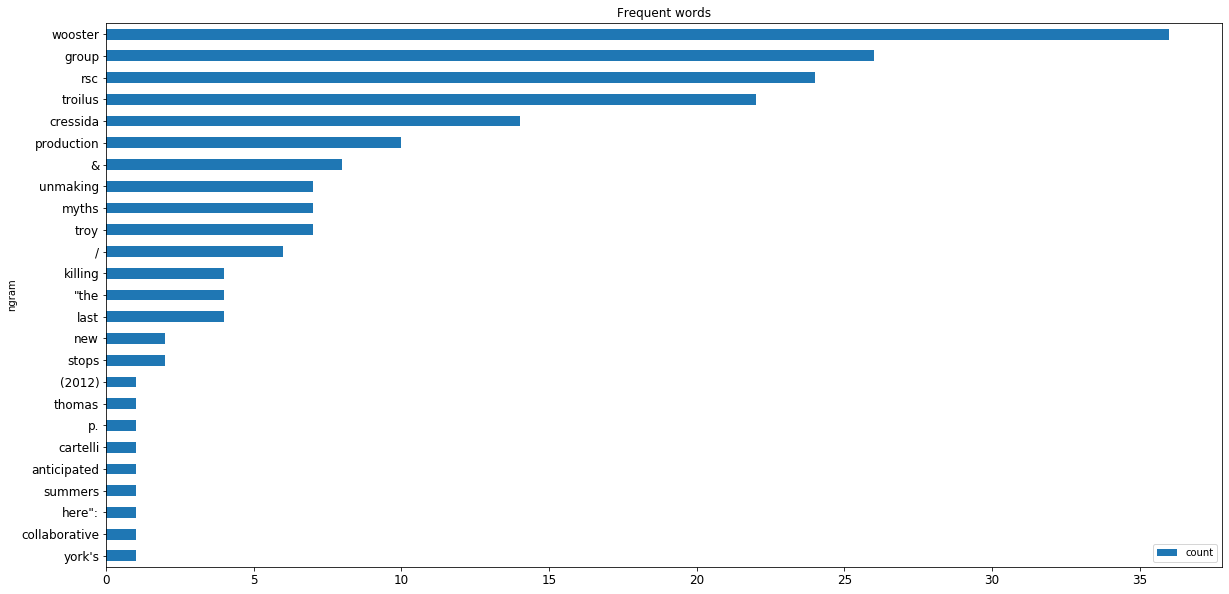

In [35]:
df.sort_values('count', ascending=True).plot.barh(title='Frequent words', figsize=(20, 10), fontsize=12, x="ngram", y="count");

---
## Using Counter to Sum the Words in a Single Article

Let's return then to the dictionary we created to hold all the words in our article. We called that variable `word_counts`. We can get a preview of the first 10 words in our dictionary using the code below.

In [ ]:
dict(list(word_counts.items())[:10]) #This code previews the first 10 items in the dictionary
# It does this by turning the `word_counts` dictionary into a list and then shows 10 items (and then turns it back into a dictionary)
# We could also use a for loop to show all the keys and values using the items() method in the word_counts dictionary
#for k,v in word_counts.items():
#    print(k + ': ' + str(v))

Note, the key/value pairs may not be in order from most frequent to least frequent words. We can sort by most frequent words by turning our dictionary `word_counts` into a Counter and then using the `most_common()` method. Let's call our new Counter object `counter_word_counts` and then print out the top 30 most common words. 

In [ ]:
counter_word_counts = Counter(word_counts) # Create `counter_word_counts` that will be Counter datatype version of our original `word_counts` dictionary
for key, value in counter_word_counts.most_common(30): # For each key/value pair in counter_word_count's top 30 most common words
    print(key.ljust(15), value) #print the `key` left justified 15 characters from the `value` 

We have successfully created a word frequency list. There are a couple small issues, however, that we still need to address:
1. There are many [function words](https://docs.tdm-pilot.org/key-terms/#function-words), words like "the", "in", and "of" that are grammatically important but do not carry as much semantic meaning like [content words](https://docs.tdm-pilot.org/key-terms/#content-words), such as nouns and verbs. 
2. The words represented here are actually case-sensitive [strings](https://docs.tdm-pilot.org/key-terms/#string). That means that the string "the" is a different from the string "The". You may notice this in your results above.

To solve these issues, we need to find a way to remove common [function words](https://docs.tdm-pilot.org/key-terms/#function-words) and combine [strings](https://docs.tdm-pilot.org/key-terms/#string) that may have capital letters in them. We can solve these issues by:

1. Using a [stopwords](https://docs.tdm-pilot.org/key-terms/#stop-words) list to remove common [function words](https://docs.tdm-pilot.org/key-terms/#function-words)
2. Lowercasing all the characters in each string to combine our counts

We could create our own stopwords list, but luckily there are many examples out there already. We'll use NLTK's [stopwords](https://docs.tdm-pilot.org/key-terms/#stop-words) list to get started.

First, we create a new list variable `stop_words` and initialize it with the common English [stopwords](https://docs.tdm-pilot.org/key-terms/#stop-words) from the [Natural Language Toolkit](https://docs.tdm-pilot.org/key-terms/#nltk) library. 

In [ ]:
# Creating a stop_words list from the NLTK. We could also use the set of stopwords from Spacy or Gensim.
from nltk.corpus import stopwords #import stopwords from nltk.corpus
stop_words = stopwords.words('english') #create a list `stop_words` that contains the English stop words list

If you're curious what is in our stopwords list, we can print a slice of the first ten words in our list to get a preview.

In [ ]:
stop_words[:10] #print the first 10 stop words in the list
#list(stop_words) #show the whole stopwords list

It may be that we want to add additional words to our stoplist. For example, we may want to remove character names. We can add items to the list by using the append method.

In [ ]:
stop_words.append("octopus")
stop_words[-10:] #evaluate and show me a slice of the last 10 items in the `stop_words` list variable

We can also add multiple words to our stoplist by using the extend() method. Notice that this method requires using a set of brackets `[]` to clarify that we are adding "gertrude" and "horatio" as list items.

In [ ]:
stop_words.extend(["kangaroo", "lemur"])
stop_words[-10:] #evaluate and show me a slice of the last 10 items in the `stop_words` list variable

We can also remove words from our list with the remove() method.

In [ ]:
stop_words.remove("octopus")
stop_words.remove("kangaroo")
stop_words.remove("lemur")
# Or to remove the last three words:
# del stop_words[-3:]
stop_words[-10:] #evaluate and show me a slice of the last 10 items in the `stop_words` list variable

## Storing Stopwords in a CSV File
We could also store our stop words in a CSV file. A CSV, or "Comma-Separated Values" file, is a plain-text file with commas separating each entry. The file could be opened and modified with a text editor or spreadsheet software such as Excel or Google Sheets. Here's what our NLTK stopwords list will look like as a CSV file opened in a plain text editor.

![The csv file as an image](https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/stopwordsCSV.png)

Let's create an example CSV.

In [ ]:
# Create a CSV file to store a set of stopwords

import csv # Import the csv module to work with csv files
outputFile = open('stop_words.csv', 'w', newline='') # Create a variable `outputFile` that will be linked to a new csv file called stop_words.csv
outputWriter = csv.writer(outputFile) # Create a writer object to add to our `outputFile`
outputWriter.writerow(stop_words) # Add our list `stop_words` to the CSV file
outputFile.close() # Close the CSV file

We have created a new file called stopWords.csv that you can open to modify. Go ahead and make a change to your stopWords.csv (either adding or subtracting words). Remember, there are no spaces between words in the CSV file. If you want to edit the CSV right inside Jupyter Lab, right-click on the file and select "Open With > Editor." 

![Selecting "Open With > Editor" in Jupyter Lab](https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/editCSV.png)

Now go ahead and add in a new word. Remember a few things:

* Each word is separated from the next word by a comma.
* There are no spaces between the words.
* You must save changes to the file if you're using a text editor, Excel, or the Jupyter Lab editor.
* You can reopen the file to make sure your changes were saved.

Now let's read our CSV file back and overwrite our original `stop_words` list variable. 

In [ ]:
# Open the CSV file and list the contents

new_stopwords_file = open('stop_words.csv') # Open `stopWords.csv` as the variable newStopwordsFile
new_stopwords_reader = csv.reader(new_stopwords_file) # Create newStopwordsReader variable to open the newStopwordsFile in Reader Mode
stop_words = list(new_stopwords_reader)[0] # Define the stop_words variable as a list to the contents of newStopwordsReader
stop_words[-10:] # Return the last ten items of the list stop_words

Refining a stopwords list for your analysis can take time. It depends on:

* What you are hoping to discover (for example, are function words important?)
* The material you are analyzing (for example, journal articles may repeat words like "abstract")

If your results are not satisfactory, you can always come back and adjust the stopwords. You may need to run your analysis many times to refine a good stopword list.
___
## Cleaning and Standardizing Tokens

We can standardize and [clean](https://docs.tdm-pilot.org/key-terms/#clean-data) up the [tokens](https://docs.tdm-pilot.org/key-terms/#token) in our [dataset](https://docs.tdm-pilot.org/key-terms/#dataset) by creating a function that passes each token through a series of tests. The function will:
* discard [tokens](https://docs.tdm-pilot.org/key-terms/#token) less than 4 characters in length
* discard [tokens](https://docs.tdm-pilot.org/key-terms/#token) with non-alphabetical characters
* lowercase all characters in each [token](https://docs.tdm-pilot.org/key-terms/#token)
* remove [stopwords](https://docs.tdm-pilot.org/key-terms/#stop-words) based on the list we created in `stop_words`

Of course, depending on your analysis and goals, you may want to change one or more the tests.

In [ ]:
# A series of tests to see whether a token should be added to our final word count.
# In order for a token to be added, it must pass all these tests.

cleaned_word_counts = Counter() # define a new variable `cleaned_word_counts` that is an empty counter type. We will store our cleaned data in it.

for token, count in counter_word_counts.items(): # For each key (`token`), value (`count`) pair in our cleaned_word_counts Counter, run the following tests...
    if len(token) < 4: # If the token is less than four characters, restart the loop with the next token
        continue
    if not token.isalpha(): # If the token contains characters that are not from the alphabet, restart the loop over with the next token
        continue
    t = token.lower() # Define a variable `t` that is an all-lowercase version of the token
    if t in stop_words: # If the token `t` is in our stop_words list, restart the loop over with the next token
        continue
    cleaned_word_counts[t] += count # Add `t` and `count` to `cleaned_word_counts`
    
print(cleaned_word_counts)

The resulting dictionary `clean_word_counts` contains only function words, lowercased, and greater than four characters. We can now print the top 25 most common words using the `most_common()` method for Counters.

In [ ]:
for key, value in cleaned_word_counts.most_common(25): # For the top 25 most common key/value pairs in `cleaned_word_counts`
    print(key.ljust(15), value) # print the key (left-justified by 15 characters) followed by the value
    # Remember that the key above corresponds to the token and the value corresponds to the number of times that token occurs

___
# Start Next Lesson: [Finding Significant Terms using TF/IDF](./1-significant-terms.ipynb)